**[Bernardo Romero - 4.4.2020](https://github.com/bromero26)**

---



# Machine Learning model - Estimate Housing Prices



Data from the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course). 
As part of the [Intermediate Machine Learning Home Page](https://www.kaggle.com/learn/intermediate-machine-learning)

![Ames Housing dataset image](https://i.imgur.com/lTJVG4e.png)


This model is my first attempt at machine learning. In the notebook I built upon what is taught in the Kaggle micro-course listed above and tweaked parameters, functions and exploratory analysis in order to achieve better performance. My goal was to develop a first understanding of key ML concepts and to get interested in moving-up the leaderboard of Kaggle competitions.  


# Step 1: Read and explore data, prepare training and validations datasets

## Read the data

In [263]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

#Read the data
X_full = pd.read_csv('train.csv', index_col='Id')
X_test_full = pd.read_csv('test.csv', index_col='Id')
print( 'The full dataset has {} rows and {} columns.'.format(X_full.shape[0], X_full.shape[1]))

The full dataset has 1460 rows and 80 columns.


## Exploratory Data Analysis

In [265]:
X_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [266]:
# Check NULL values in dataset
missing_val_count_by_column = (X_full.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [267]:
# Variables with mostly NUlls
many_nulls = ['FireplaceQu','Alley','PoolQC','Fence','MiscFeature']

#Suspected leakage features
leakage_sus = ['YrSold','SaleCondition','MoSold']

#Change from numeric to categorical
X_full['MSSubClass'] = X_full['MSSubClass'].astype('object')

# features with useless content. Different feature/values combinations
useless = ['MiscVal','MiscFeature']
to_drop = many_nulls + leakage_sus + useless

X_full.drop(to_drop, axis=1, inplace = True)
X_test_full.drop(to_drop, axis=1, inplace = True)


In [268]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

The target variable, `SalePrice`, has no NULL values

From the data dictionary and the previous informations, I suspect the following features to be correlated to sales price: 
- LotArea
- Neighborhood
- OverallQual
- OverallCond
- Total square feet: sum of 1stFlrSF and 2ndFlrSF

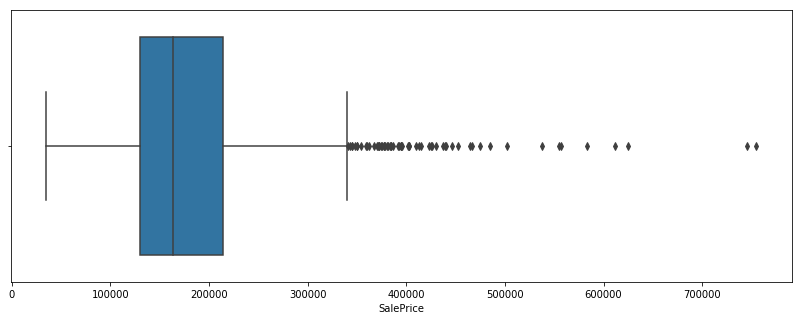

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))
sns.boxplot(x='SalePrice', data=X_full);

In [270]:
# Is GrLivArea (living area surface), the addition of 1st and 2nd floor square feet?
# X_full[['GrLivArea', '1stFlrSF', '2ndFlrSF']].head()
X_full['GrLivArea']-X_full['1stFlrSF']-X_full['2ndFlrSF']

Id
1       0
2       0
3       0
4       0
5       0
       ..
1456    0
1457    0
1458    0
1459    0
1460    0
Length: 1460, dtype: int64

It seems it is the case... but not always. Look:

In [271]:
(X_full['GrLivArea']-X_full['1stFlrSF']-X_full['2ndFlrSF']).sum()

8533

In [272]:
# I'll add a variable with the total square feet of the house, and then with a 
# correlation matrix see which of the two has a stronger correlation to Sale Price

X_full['total_sqrft'] = X_full['1stFlrSF'] + X_full['2ndFlrSF']
X_test_full['total_sqrft'] = X_test_full['1stFlrSF'] + X_test_full['2ndFlrSF']

In [273]:
X_full[['SalePrice', 'GrLivArea', 'total_sqrft']].corr()

,SalePrice,GrLivArea,total_sqrft
SalePrice,1.000000,0.708624,0.716883
GrLivArea,0.708624,1.000000,0.995718
total_sqrft,0.716883,0.995718,1.000000


In [274]:
# Drop the "general living area" feature

X_full.drop(['GrLivArea'], axis=1, inplace=True)
X_test_full.drop(['GrLivArea'], axis=1, inplace=True)

I will now look at the correlation between the suspected variables by means of a pairplot:

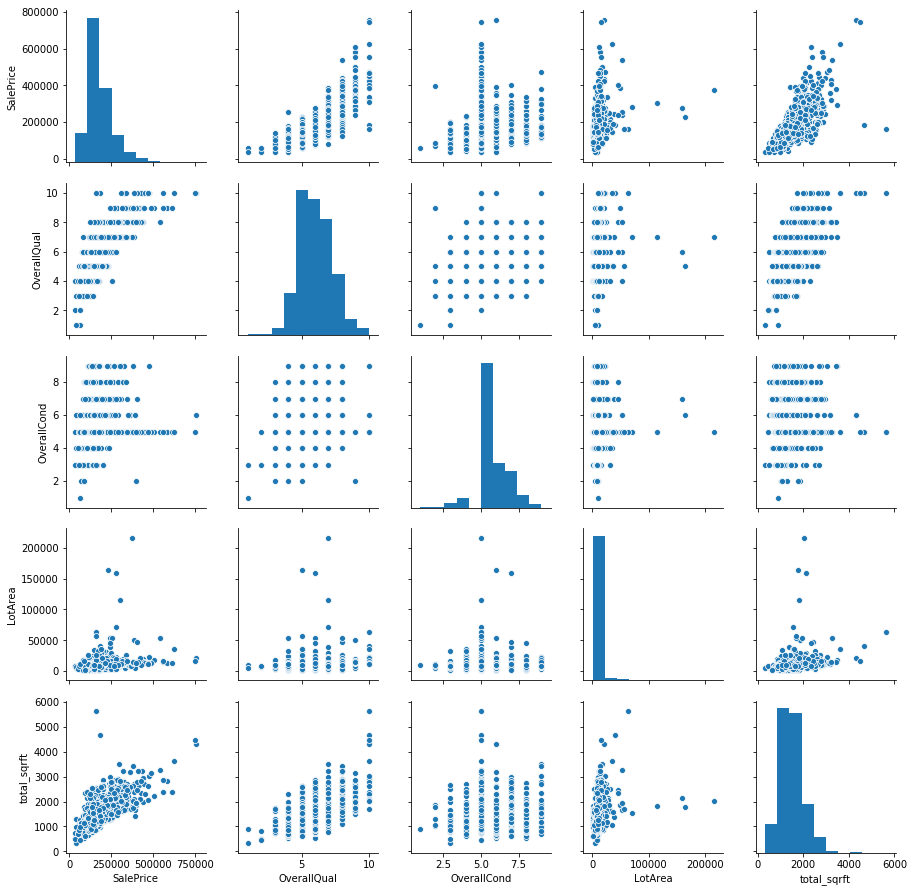

In [275]:
sns.pairplot(X_full[['SalePrice', 'OverallQual', 'OverallCond', 'LotArea', 'total_sqrft']]);

In [276]:
# Calculating correlations
X_full[['SalePrice', 'OverallQual', 'OverallCond', 'LotArea', 'total_sqrft']].corr()

,SalePrice,OverallQual,OverallCond,LotArea,total_sqrft
SalePrice,1.000000,0.790982,-0.077856,0.263843,0.716883
OverallQual,0.790982,1.000000,-0.091932,0.105806,0.600758
OverallCond,-0.077856,-0.091932,1.000000,-0.005636,-0.082724
LotArea,0.263843,0.105806,-0.005636,1.000000,0.264850
total_sqrft,0.716883,0.600758,-0.082724,0.264850,1.000000


There is a strong correlation between Sale Price and overall quality and  total square feet. To a lesser degree the lot size and not at all the overall condition. I'll check some other numerical features:

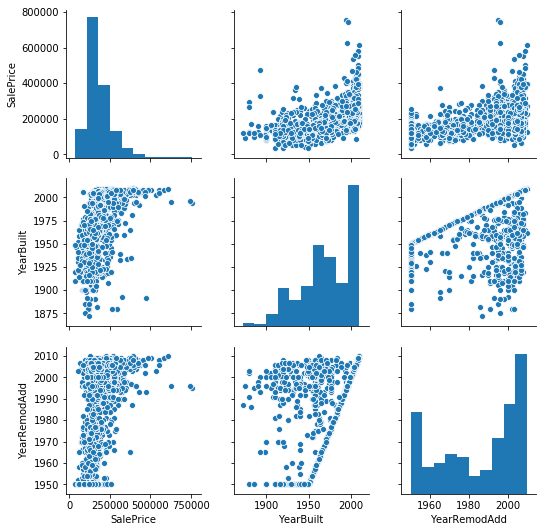

In [277]:
sns.pairplot(X_full[['SalePrice','YearBuilt', 'YearRemodAdd']]);

In [278]:
# Calculating correlations
X_full[['SalePrice','MSSubClass','YearBuilt', 'YearRemodAdd']].corr()

,SalePrice,YearBuilt,YearRemodAdd
SalePrice,1.000000,0.522897,0.507101
YearBuilt,0.522897,1.000000,0.592855
YearRemodAdd,0.507101,0.592855,1.000000


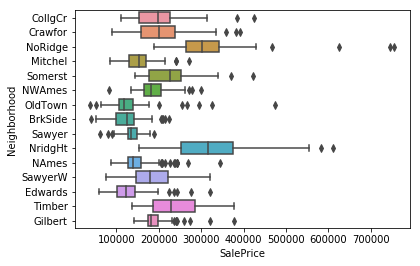

In [279]:
top_neighborhoods = X_full['Neighborhood'].value_counts().head(15).index.values
sns.boxplot(y="Neighborhood", x="SalePrice", 
            data=X_full[X_full['Neighborhood'].isin(top_neighborhoods)], orient="h");

## Split training and validation data

In [283]:
# set target variable
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

#Separate training and validation data
X_train_full, X_val_full, y_train, y_val = train_test_split(X_full, y
                                                            ,train_size=0.8, test_size=0.2
                                                            ,random_state=0)

#Removing high-cardinality features
categorical_cols = [col for col in X_full.columns if
                   X_full[col].nunique()<10 and
                   X_full[col].dtype == 'object']

#Selecting numeric features
numerical_cols = [col for col in X_full.columns if
                  X_full[col].dtype in['int64', 'float64']]

#Putting them together
my_cols = categorical_cols + numerical_cols

# new datasets only with selected columns
X_train = X_train_full[my_cols].copy()
X_val = X_val_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# Step 2: Preprocess the data (Pipelines)

In [285]:
# Preprocessing for numerical data

numerical_transformer = SimpleImputer(strategy='median')


# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Step 3 Model

## Model 1: Decision Tree

In [286]:
# Helpful function to evaluate different parameters

def get_mae_tree(max_leaf_nodes, X_train, X_val, y_train, y_val):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return(mae)

# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [10, 30, 50, 70, 100, 110, 120]:
    my_mae = get_mae_tree(max_leaf_nodes, X_train, X_val, y_train, y_val)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 10  		 Mean Absolute Error:  30494
Max leaf nodes: 30  		 Mean Absolute Error:  27744
Max leaf nodes: 50  		 Mean Absolute Error:  26631
Max leaf nodes: 70  		 Mean Absolute Error:  26538
Max leaf nodes: 100  		 Mean Absolute Error:  25741
Max leaf nodes: 110  		 Mean Absolute Error:  26208
Max leaf nodes: 120  		 Mean Absolute Error:  26726


 A Tree with 100 nodes would work best for this model. We can also use another approach, adding MAE values to a dictionary and selecting the number of leaf nodes corresponding to the lowest MAE

In [287]:
candidate_max_leaf_nodes = [5, 25, 50, 100, 110, 150, 170, 300]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes

maes = {}
for max_leaf_nodes in candidate_max_leaf_nodes:
    my_mae = get_mae_tree(max_leaf_nodes, X_train, X_val, y_train, y_val)
    maes.update({max_leaf_nodes:my_mae})

# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = min(maes, key=maes.get)
best_tree_size

100

## Model 2 - Random Forests

In [288]:
# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_val)

print('MAE:', mean_absolute_error(y_val, preds))

MAE: 17026.2447260274


Random forests provide a much better MAE than a single decision tree. I will now test with different number of estimators:

In [237]:
def get_mae_rf(n_estimators, X_train, X_val, y_train, y_val):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return(mae)

# compare MAE with differing values of max_leaf_nodes
for n_estimators in [100, 200, 300, 400, 500, 1000]:
    my_mae = get_mae_rf(n_estimators, X_train, X_val, y_train, y_val)
    print("n_estimators: %d  \t\t Mean Absolute Error:  %d" %(n_estimators, my_mae))

n_estimators: 100  		 Mean Absolute Error:  17026
n_estimators: 200  		 Mean Absolute Error:  17028
n_estimators: 300  		 Mean Absolute Error:  16929
n_estimators: 400  		 Mean Absolute Error:  16977
n_estimators: 500  		 Mean Absolute Error:  16981
n_estimators: 1000  		 Mean Absolute Error:  17026


A forest with 300 trees perform with this set of features.

## Model 3 - XGBoost

In [290]:
# Define model
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=300, learning_rate=0.02)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', my_model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

predictions = clf.predict(X_val)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_val)))

Mean Absolute Error: 16872.286012414384


XGBoost is also an improvement over random forests. I will now test it with several different number of estimators and learning rates

In [291]:
# Function to test several n_estimators values for XGBoost, with a constant learning rate of 0.05

def get_mae_xgb(n_estimators, X_train, X_val, y_train, y_val):
    model = XGBRegressor(n_estimators=n_estimators, random_state=0, learning_rate=0.02)
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return(mae)

# compare MAE with differing values of max_leaf_nodes
for n_estimators in [100, 200, 300, 400, 500, 1000]:
    my_mae = get_mae_xgb(n_estimators, X_train, X_val, y_train, y_val)
    print("XGBoost n_estimators: %d  \t\t Mean Absolute Error:  %d" %(n_estimators, my_mae))

XGBoost n_estimators: 100  		 Mean Absolute Error:  28986
XGBoost n_estimators: 200  		 Mean Absolute Error:  17344
XGBoost n_estimators: 300  		 Mean Absolute Error:  16872
XGBoost n_estimators: 400  		 Mean Absolute Error:  16696
XGBoost n_estimators: 500  		 Mean Absolute Error:  16598
XGBoost n_estimators: 1000  		 Mean Absolute Error:  16601


In [292]:
# Same function as above, with a lower learning rate

def get_mae_xgb(n_estimators, X_train, X_val, y_train, y_val):
    model = XGBRegressor(n_estimators=n_estimators, random_state=0, learning_rate=0.01)
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return(mae)

# compare MAE with differing values of max_leaf_nodes
for n_estimators in [100, 200, 300, 400, 500, 1000]:
    my_mae = get_mae_xgb(n_estimators, X_train, X_val, y_train, y_val)
    print("XGBoost n_estimators: %d  \t\t Mean Absolute Error:  %d" %(n_estimators, my_mae))

XGBoost n_estimators: 100  		 Mean Absolute Error:  68738
XGBoost n_estimators: 200  		 Mean Absolute Error:  29153
XGBoost n_estimators: 300  		 Mean Absolute Error:  19176
XGBoost n_estimators: 400  		 Mean Absolute Error:  17286
XGBoost n_estimators: 500  		 Mean Absolute Error:  16821
XGBoost n_estimators: 1000  		 Mean Absolute Error:  16436


XGBoost performs best with larger number of estimators (1000) and lower learning rate (0.01)

## Model 3 - XGBoost - Parameter tuning

In [294]:
# Preprocessing for numerical data

my_imputer_num = SimpleImputer(strategy='median')

imputed_X_train_num = pd.DataFrame(my_imputer_num.fit_transform(X_train[numerical_cols]))
imputed_X_val_num = pd.DataFrame(my_imputer_num.transform(X_val[numerical_cols]))
imputed_X_test_num = pd.DataFrame(my_imputer_num.transform(X_test[numerical_cols]))

imputed_X_train_num.columns = X_train[numerical_cols].columns
imputed_X_val_num.columns = X_val[numerical_cols].columns
imputed_X_test_num.columns = X_test[numerical_cols].columns

In [296]:
#Preprocessing for categorical data

my_imputer_cat = SimpleImputer(strategy='most_frequent')

imputed_X_train_cat = pd.DataFrame(my_imputer_cat.fit_transform(X_train[categorical_cols]))
imputed_X_val_cat = pd.DataFrame(my_imputer_cat.transform(X_val[categorical_cols]))
imputed_X_test_cat = pd.DataFrame(my_imputer_cat.transform(X_test[categorical_cols]))

imputed_X_train_cat.columns = X_train[categorical_cols].columns
imputed_X_val_cat.columns = X_val[categorical_cols].columns
imputed_X_test_cat.columns = X_test[categorical_cols].columns

In [298]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(imputed_X_train_cat))
OH_cols_val = pd.DataFrame(OH_encoder.transform(imputed_X_val_cat))
OH_cols_test = pd.DataFrame(OH_encoder.transform(imputed_X_test_cat))

# One-hot encoding removed index; put it back
OH_cols_train.index = imputed_X_train_cat.index
OH_cols_val.index = imputed_X_val_cat.index
OH_cols_test.index = imputed_X_test_cat.index

In [300]:
# Add one-hot encoded columns to numerical features
X_train_fin = pd.concat([imputed_X_train_num, OH_cols_train], axis=1)
X_val_fin = pd.concat([imputed_X_val_num, OH_cols_val], axis=1)
X_test_fin = pd.concat([imputed_X_test_num, OH_cols_test], axis=1)

In [302]:
# Define model
my_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.01)

# fit model 
my_model3.fit(X_train_fin, y_train
             ,early_stopping_rounds=5
             ,eval_set=[(X_val_fin, y_val)]
             ,verbose=False)

predictions_model3 = my_model3.predict(X_val_fin)
print("Mean Absolute Error Model 3: " + str(mean_absolute_error(predictions_model3, y_val)))

Mean Absolute Error Model 3: 16445.024668236303


This approach provides the lowest MAE so far and I will use it to make predictions for the test data and submit to Kaggle. Here's where my current skills in Machine Learning end, after the beginner and intermediate ML courses.

In [249]:
# Preprocessing for numerical data

my_imputer_num = SimpleImputer(strategy='median')
imputed_X_test_num = pd.DataFrame(my_imputer_num.fit_transform(X_test[numerical_cols]))
imputed_X_test_num.columns = X_test[numerical_cols].columns

#Preprocessing for categorical data

my_imputer_cat = SimpleImputer(strategy='most_frequent')
imputed_X_test_cat = pd.DataFrame(my_imputer_cat.fit_transform(X_test[categorical_cols]))
imputed_X_test_cat.columns = X_test[categorical_cols].columns


# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(imputed_X_test_cat))

# One-hot encoding removed index; put it back
OH_cols_test.index = imputed_X_test_cat.index

# Add one-hot encoded columns to numerical features
X_test_fin = pd.concat([imputed_X_test_num, OH_cols_test], axis=1)

In [316]:
# Test the shape of train and test datasets
print(X_val_fin.shape)
print(X_test_fin.shape)

(292, 200)
(1459, 200)


In [311]:
# Re-set the index in order to match the submission guidelines of Kaggle
X_test_fin['ID'] = pd.Series(range(1461,2920,1))
X_test_fin.set_index('ID', drop=True, inplace=True)

In [313]:
# Save test predictions to file
preds_test = my_model3.predict(X_test_fin)
output = pd.DataFrame({'Id': X_test_fin.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

In [315]:
output.head()

,Id,SalePrice
0,1461,125826.617188
1,1462,148895.093750
2,1463,190076.765625
3,1464,190517.640625
4,1465,194516.656250


---
**[Intermediate Machine Learning Home Page](https://www.kaggle.com/learn/intermediate-machine-learning)**


The submission allowed me to scale a few more places up the leaderboard: 

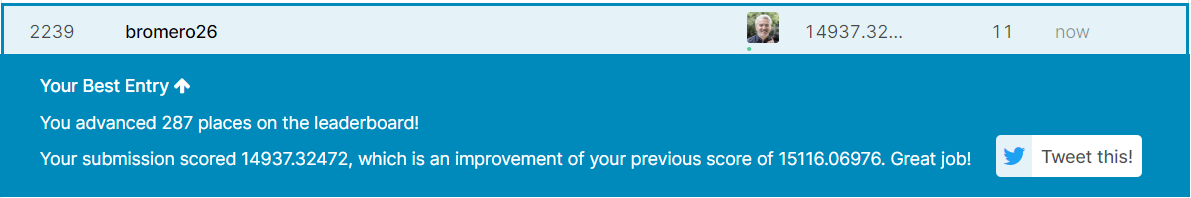

# Not bad!

## Resources
- https://datascience.stackexchange.com/questions/29028/different-number-of-features-after-using-onehotencoder
Discussion about One-Hot encoding: should be performed before or after splitting the data?

- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html#pandas.DataFrame.set_index
Set_index with pandas

## Open questions
- I need to be able to test different XGBoost parameters inside of a pipeline. In this notebook I had to revert the pipeline to do it. The way to go seems to be [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

- I can do much better in encoding categorical features. Neighborhood correlates to Price, but for this submission I didn't take it into consideration. It got excluded when I removed categorical features with cardinality >=10


